Simple survival analysis - example
---

In [1]:
import lifelines as surv
import pandas as pd
import matplotlib.pylab as plt

Read data: _X_ is the expression matrix `[patients x genes]` and _C_ is the clinical data frame with several covariates of interest.

In [2]:
X = pd.read_hdf('petacc3-student_project.h5', key='X')
C = pd.read_hdf('petacc3-student_project.h5', key='clinical')

In [3]:
X.head()

,NAT2,ADA,CDH2,AKT3,MED6,NAALAD2,NAALADL1,ACOT8,ABI1,GNPDA1,...,RCE1,HNRPDL,DMTF1,PPP4R1,CDH1,SLC12A6,ROD1,DGCR2,CASP8AP2,SCO2
KU008,1.451219,4.054724,4.525082,4.034952,3.046681,1.607111,2.249023,4.176643,7.580103,3.102467,...,4.591567,8.780527,4.560509,6.337588,8.503087,3.223257,4.77594,7.207375,6.082262,5.051237
SA001,1.287009,4.355784,4.018522,2.102942,3.880011,2.313341,2.629223,4.725783,5.940103,2.535407,...,5.613197,6.366317,5.479479,4.327098,6.749827,3.040607,6.33225,5.608725,4.808102,5.445647
F6004,1.345129,4.655144,4.362052,2.510192,3.930471,2.095541,2.916913,4.774883,5.964063,3.233657,...,4.772987,7.134557,3.175759,4.479788,7.662617,3.246437,6.00346,5.744985,6.116412,4.629227
U4024,2.058609,3.955264,5.711552,2.820302,4.190321,1.581841,2.726893,4.896003,6.099253,2.040327,...,5.029057,7.535257,4.585459,4.817858,6.922617,3.316917,6.27375,5.016285,7.116272,5.400207
A1005,2.381069,4.451534,4.534742,3.015402,3.374131,1.980091,2.517693,4.142483,6.750993,1.428257,...,4.095797,9.749397,5.282589,5.611358,7.262377,3.387307,5.20247,6.486585,6.657742,5.338907


In [4]:
C.head()

,os.event,os.time,rfs.event,rfs.time,trtgrp,grade,MSI,site,stage,BRAF,KRAS
rownames,,,,,,,,,,,
KU008,False,51.186858,True,9.560575,5-FU/FA,G-12,MSS,left,3,wt,wt
SA001,False,71.589322,False,71.589322,FOLFIRI,G-12,MSS,left,3,wt,wt
F6004,False,65.577002,False,65.577002,FOLFIRI,G-12,NaN,left,3,wt,mut
U4024,False,68.796715,False,68.796715,FOLFIRI,G-12,NaN,right,3,wt,mut
A1005,False,70.965092,False,70.965092,5-FU/FA,G-12,MSS,left,3,wt,mut


Survival-related variables are **os...** and **rfs...** for **overall** and **relapse-free** survival, respectively. They are encoded as a pair of variables (**.time** and **.event**) where time indicates the duration in months until either the event (death or relapse) happened (if **.event** is True) or the patient was lost for follow-up (**.event** is False), _i.e._ was censored. Of interest, for the project, is the **relapse-free survival** and the effect of treatment (encoded in **trtgrp** variable) on this outcome. The goal is to allow the user to explore whether a gene (columns of __X__) are predictive of differential response to treatment, with or without accounting for the effect of other covariates (like __grade__, __stage__ or mutation status of __KRAS__ and/or __BRAF__ genes). All these covariates could be included in the regression model as factors (they have discrete values) or they can be used to define a subpopulation of interest (_e.g._ patients with `stage == 3` and `MSI==MSS`) within which the __gene__ of interest could be tested.

General patient population survival curves - Kaplan-Meier estimator
--

In [5]:
# Check the documentation!!!
estm = surv.KaplanMeierFitter(label='all patients')
_ = estm.fit(
    C['rfs.time'],   # time to event or censoring
    C['rfs.event']   # True -> event
)

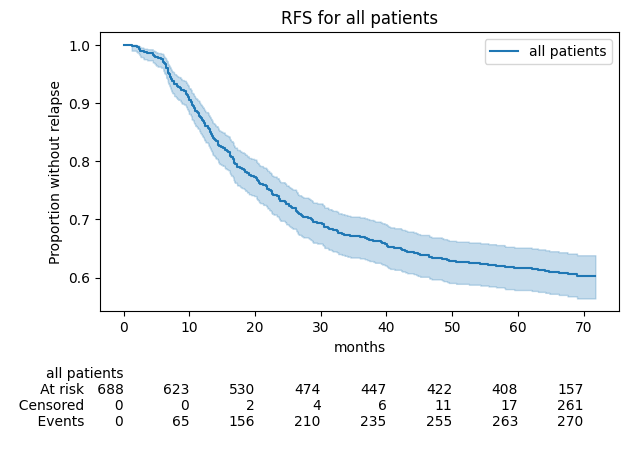

In [6]:
_ = estm.plot_survival_function(
    title='RFS for all patients', 
    xlabel='months', 
    ylabel='Proportion without relapse',
    at_risk_counts=True,
    loc=slice(0., 72.)
)

You can also see whether the treatment had any effect:

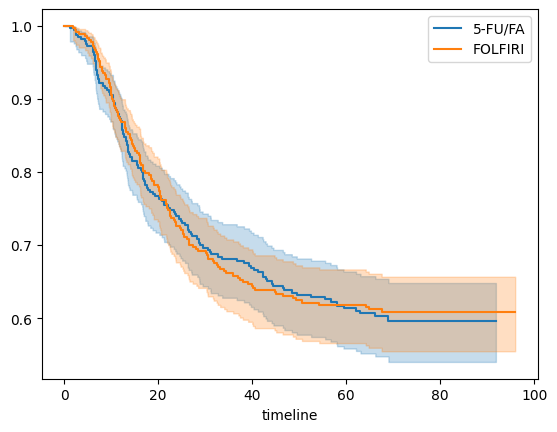

In [7]:
estm2 = surv.KaplanMeierFitter()

ax = plt.subplot(111)

for name, grp in C.groupby('trtgrp'):
    estm2.fit(grp['rfs.time'], grp['rfs.event'], label=name)
    estm2.plot_survival_function(ax=ax)

There seems to be no effect of the treatment within the general patient population.

**How would you statistically test this hypothesis?** 

Predictive genes
--

Consider you have a gene of interest, for example **DUSP5**. Let's see whether there is an interaction with treatment, within microsatellite-stable, stage III patients.

**How would you statistically test this?**

In [8]:
# patients with MSS, stage III tumors
pts = C.loc[(C['MSI'] == 'MSS') & (C['stage'] == 3)].dropna().index

In [9]:
pts

Index(['KU008', 'SA001', 'A1005', 'C2009', 'EH011', 'V0009', 'G4003', 'K8003',
       'UC032', 'U4035',
       ...
       'KE001', 'MA005', 'V3006', 'W4004', 'UH005', 'RL001', 'H4003', 'LJ003',
       'R1004', 'C2003'],
      dtype='object', name='rownames', length=462)

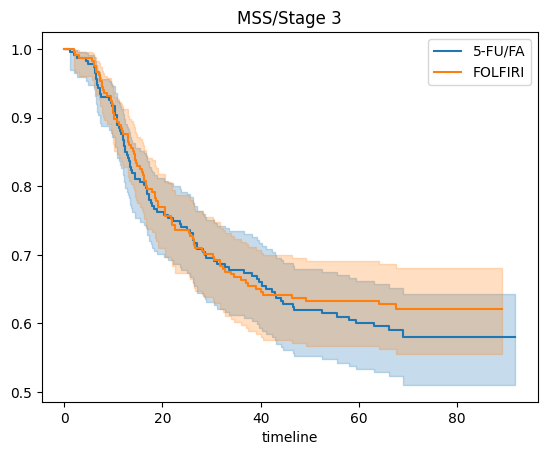

In [10]:
estm3 = surv.KaplanMeierFitter()

ax = plt.subplot(111)

for name, grp in C.loc[pts].groupby('trtgrp'):
    estm3.fit(grp['rfs.time'], grp['rfs.event'], label=name)
    estm3.plot_survival_function(ax=ax)
_ = ax.set_title('MSS/Stage 3')

In [11]:
gene_name = 'DUSP5'
cut_off = X[gene_name].median()
Z = pd.DataFrame(index=pts)
Z['rfs.time'] = C.loc[pts]['rfs.time']
Z['rfs.event'] = C.loc[pts]['rfs.event']
Z['trtm'] = C.loc[pts]['trtgrp']
Z['gene_high'] = X.loc[pts]['DUSP5'] >= cut_off
Z.head()

,rfs.time,rfs.event,trtm,gene_high
rownames,,,,
KU008,9.560575,True,5-FU/FA,True
SA001,71.589322,False,FOLFIRI,False
A1005,70.965092,False,5-FU/FA,True
C2009,16.722793,True,5-FU/FA,True
EH011,67.383984,False,FOLFIRI,True


In [12]:
cut_off

np.float64(5.089386324178223)

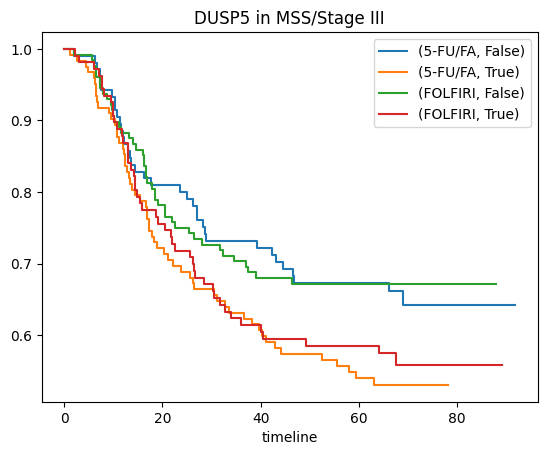

In [13]:
estm4 = surv.KaplanMeierFitter()

ax = plt.subplot(111)

for name, grp in Z.groupby([Z['trtm'], Z['gene_high']]):
    estm4.fit(grp['rfs.time'], grp['rfs.event'], label=name)
    estm4.plot_survival_function(ax=ax, ci_show=False)
_ = ax.set_title('DUSP5 in MSS/Stage III')

**DUSP5**: The protein encoded by this gene is a member of the dual specificity protein phosphatase subfamily. 
These phosphatases inactivate their target kinases by dephosphorylating both the phosphoserine/threonine and phosphotyrosine residues. They negatively regulate members of the mitogen-activated protein (MAP) kinase superfamily (MAPK/ERK, SAPK/JNK, p38), which are associated with cellular proliferation and differentiation. Different members of the family of dual specificity phosphatases show distinct substrate specificities for various MAP kinases, different tissue distribution and subcellular localization, and different modes of inducibility of their expression by extracellular stimuli. This gene product inactivates ERK1, is expressed in a variety of tissues with the highest levels in pancreas and brain, and is localized in the nucleus.